# cosine schedule

A fairly simple Improvement to our ddim implementation for fashion mnist.
Changes to make life simpler, reflecting the way the papers have been evolving, better and simpler.

In [1]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [2]:
from fastprogress import progress_bar
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

In [3]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 512
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

Recent papers no longer have a concept of end? steps, which always bothered us this capital T.
t over T is saying timestep number 500 out of 1000, so it's timestep 0.5, thus lets just call it 0.5. 
We are going to use the cosine scheduler and let's get rid of the steps and the capital T.
Here is `abar` again and now without the capital T.
Now a timestep is between 0-1, and it represents what percentage of the way through the diffusion process we are at.
0 would be plain image and 1 all noise.
Other than that this is the same equation we've already seen.
We can take the inverse to calculate T.
First take the square root, and then take the inverse cos and then divide by 2 over pi or times pi over 2. 
Now we don't look up alphabar in a list, we calculate with a function from a float.
That means we can also calculate T from an alphabar.

In [5]:
def abar(t): return (t*math.pi/2).cos()**2
def inv_abar(x): return x.sqrt().acos()*2/math.pi

`noiseify` has changed a little. 
We get the alphabar for the timestep `t` by calling `abar(t)`. 
The timestep `t` is a random float between zero and 0.999. (Is the clamp required for 0.999?)
Noisify is returning the `xt`, the timestep `t` which is now a float, and the noise $\epsilon$ 
that's the thing we're going to predict.
The dependent variable is the tuple (xt, t) which are inputs to the model.

In [6]:
def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand(n,).to(x0).clamp(0,0.999)
    ε = torch.randn(x0.shape, device=device)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [7]:
def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [8]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

dl = dls.train
(xt,t),eps = b = next(iter(dl))

Here is what that looks like.
When we look at our input to the training process, a `t=0.05` through the forward diffusion process looks like this,
and at .65 through it looks like this.
The model is the same, the callbacks are the same, the fitting process is the same.

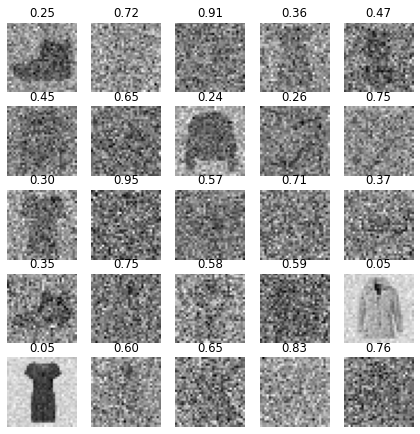

In [9]:
show_images(xt[:25], imsize=1.5, titles=fc.map_ex(t[:25], '{:.02f}'))

In [10]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [11]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [12]:
lr = 4e-3
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

/Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


/Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


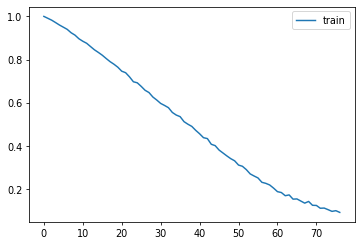

In [ ]:
learn.fit(epochs)

In [ ]:
# torch.save(learn.model, 'models/fashion_cos.pkl')
model = learn.model = torch.load('models/fashion_cos.pkl').cuda()

We define a `denoise` function so we can take a batch of data that we generated, the noisified data,
(here it is again), and we can denoise it.
We know the `t` for each element (`t` is different for each element now),
so we can calculate the alphabar `abar_t` for each element, and then we can undo the noisification to get the denoised version.
We do it and we get what is shown below, which shows what actually happens when we run a single step of the model,
on varyingly partially noised images.
This is something not seen often, as not many people are working in interactive notebook environments.
It is helpful to get a sense of, e.g., if you're .25 or .95 of the way through the forward diffusion process,
this is what it looks like when you undo that.

In [ ]:
def denoise(x_t, noise, t):
    device = x_t.device
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    return ((x_t-(1-abar_t).sqrt()*noise) / abar_t.sqrt()).clamp(-1,1)

In [ ]:
with torch.no_grad(): noise=learn.model((xt.cuda(),t.cuda()))

In [ ]:
show_images(xt[:25], imsize=1.5, titles=fc.map_ex(t[:25], '{:.02f}'))

In [ ]:
show_images(denoise(xt.cuda(),noise,t.cuda())[:25].clamp(-1,1), imsize=1.5, titles=fc.map_ex(t[:25], '{:.02f}'))

## Sampling

In [ ]:
from miniai.fid import ImageEval

In [ ]:
cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

In [ ]:
sz = (2048,1,32,32)

In [ ]:
sz = (256,1,32,32)

In [ ]:
def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig):
    sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
    x_0_hat = ((x_t-(1-abar_t).sqrt()*noise) / abar_t.sqrt()).clamp(-1.5,1.5)
    if bbar_t1<=sig**2+0.01: sig=0.  # set to zero if very small or NaN
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_0_hat,x_t

In [ ]:
@torch.no_grad()
def sample(f, model, sz, steps, eta=1.):
    ts = torch.linspace(1-1/steps,0,steps)
    x_t = torch.randn(sz).to(model.device)
    preds = []
    for i,t in enumerate(progress_bar(ts)):
        abar_t = abar(t)
        noise = model((x_t, t))
        abar_t1 = abar(t-1/steps) if t>=1/steps else torch.tensor(1)
#         print(abar_t,abar_t1,x_t.min(),x_t.max())
        x_0_hat,x_t = f(x_t, noise, abar_t, abar_t1, 1-abar_t, 1-abar_t1, eta, 1-((i+1)/100))
        preds.append(x_0_hat.float().cpu())
    return preds

In [ ]:
# set_seed(42)
preds = sample(ddim_step, model, sz, steps=100, eta=1.)
s = (preds[-1]*2)
s.min(),s.max(),s.shape

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
ie.fid(s),ie.kid(s),s.shape

In [ ]:
preds = sample(ddim_step, model, sz, steps=100, eta=1.)
ie.fid(preds[-1]*2)

In [ ]:
preds = sample(ddim_step, model, sz, steps=50, eta=1.)
ie.fid(preds[-1]*2)